In [114]:
order_classes = [
    "SNIa", "SNIbc", "SNIIb", "SNII", "SNIIn", "SLSN", 
    "TDE", "Microlensing", "QSO", "AGN", "Blazar", 
    "YSO", "CV/Nova", "LPV", "EA", "EB/EW", 
    "Periodic-Other", "RSCVn", "CEP", "RRLab", "RRLc", "DSCT"
]

class_hierarchy = {
    "Transient": ["SNIa", "SNIbc", "SNIIb", "SNII", "SNIIn", "SLSN", "TDE"],
    "Periodic": [
        "LPV",
        "EA",
        "EB/EW",
        "Periodic-Other",
        "RSCVn",
        "CEP",
        "RRLab",
        "RRLc",
        "DSCT",
    ],
    "Stochastic": [
        "QSO",
        "AGN",
        "Blazar",
        "YSO",
        "CV/Nova",
        "Microlensing",  # ulens get confused with stochastic classes
    ],
}

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def get_confusion_matrix(mean_matrix, std_matrix, mean_matrices_norm, order_classes, class_hierarchy, path_save=None, figsize=(13, 13)):
    # Graficando la matriz media
    cmap = plt.cm.Blues
    fig, ax = plt.subplots(figsize=figsize) #, dpi=110)
    #norm = mcolors.Normalize(vmin=0, vmax=np.max(mean_matrix))
    #mean_matrix = 
    im = ax.imshow(np.around(mean_matrices_norm, decimals=2), interpolation='nearest', cmap=cmap, aspect=0.80, vmax=1)#, #norm=norm)

    #divider = make_axes_locatable(ax)
    #cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, ax=ax, pad=0.02, aspect=40)
    cbar.ax.tick_params(labelsize=17)

    # color map
    new_color = cmap(1.0) 

    # Añadiendo manualmente las anotaciones con la media y desviación estándar
    for i in range(mean_matrix.shape[0]):
        for j in range(mean_matrix.shape[1]):
            if mean_matrices_norm[i, j] >= 0.0005:
                #print(mean_matrix[i, j])
                text = f'{np.around(mean_matrix[i, j], decimals=2)}\n±{np.around(std_matrix[i, j], decimals=2)}'
                color = "white" if mean_matrices_norm[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
                ax.text(j, i, text, ha="center", va="center", color=color, fontsize=12.5)
            else:
                text = f'{np.around(mean_matrix[i, j], decimals=2)}'
                color = "white" if mean_matrices_norm[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
                ax.text(j, i, text, ha="center", va="center", color=color, fontsize=12.5)

    # Ajustes finales y mostrar la gráfica
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xticks(np.arange(len(order_classes)))
    ax.set_yticks(np.arange(len(order_classes)))
    ax.set_xticklabels(order_classes)
    ax.set_yticklabels(order_classes)
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    ax.xaxis.labelpad = 13
    ax.yaxis.labelpad = 13

    for class_list in class_hierarchy.values():
        indices = [order_classes.index(cls) for cls in class_list if cls in order_classes]
        if indices:
            min_idx, max_idx = min(indices), max(indices)
            rect = patches.Rectangle(
                (min_idx - 0.5, min_idx - 0.5),  # Esquina superior izquierda
                max_idx - min_idx + 1,  # Ancho
                max_idx - min_idx + 1,  # Alto
                linewidth=2, edgecolor="black", facecolor='none', clip_on=False
            )
            ax.add_patch(rect)


    ax.set_ylabel('True Label', fontsize=17)
    ax.set_xlabel('Predicted Label', fontsize=17)

    plt.setp(ax.get_xticklabels(), rotation=65, ha='center', va='top', rotation_mode="default")

    if path_save is not None:
        plt.savefig(f"{path_save}", format="pdf", bbox_inches="tight")

    plt.tight_layout()
    plt.show()

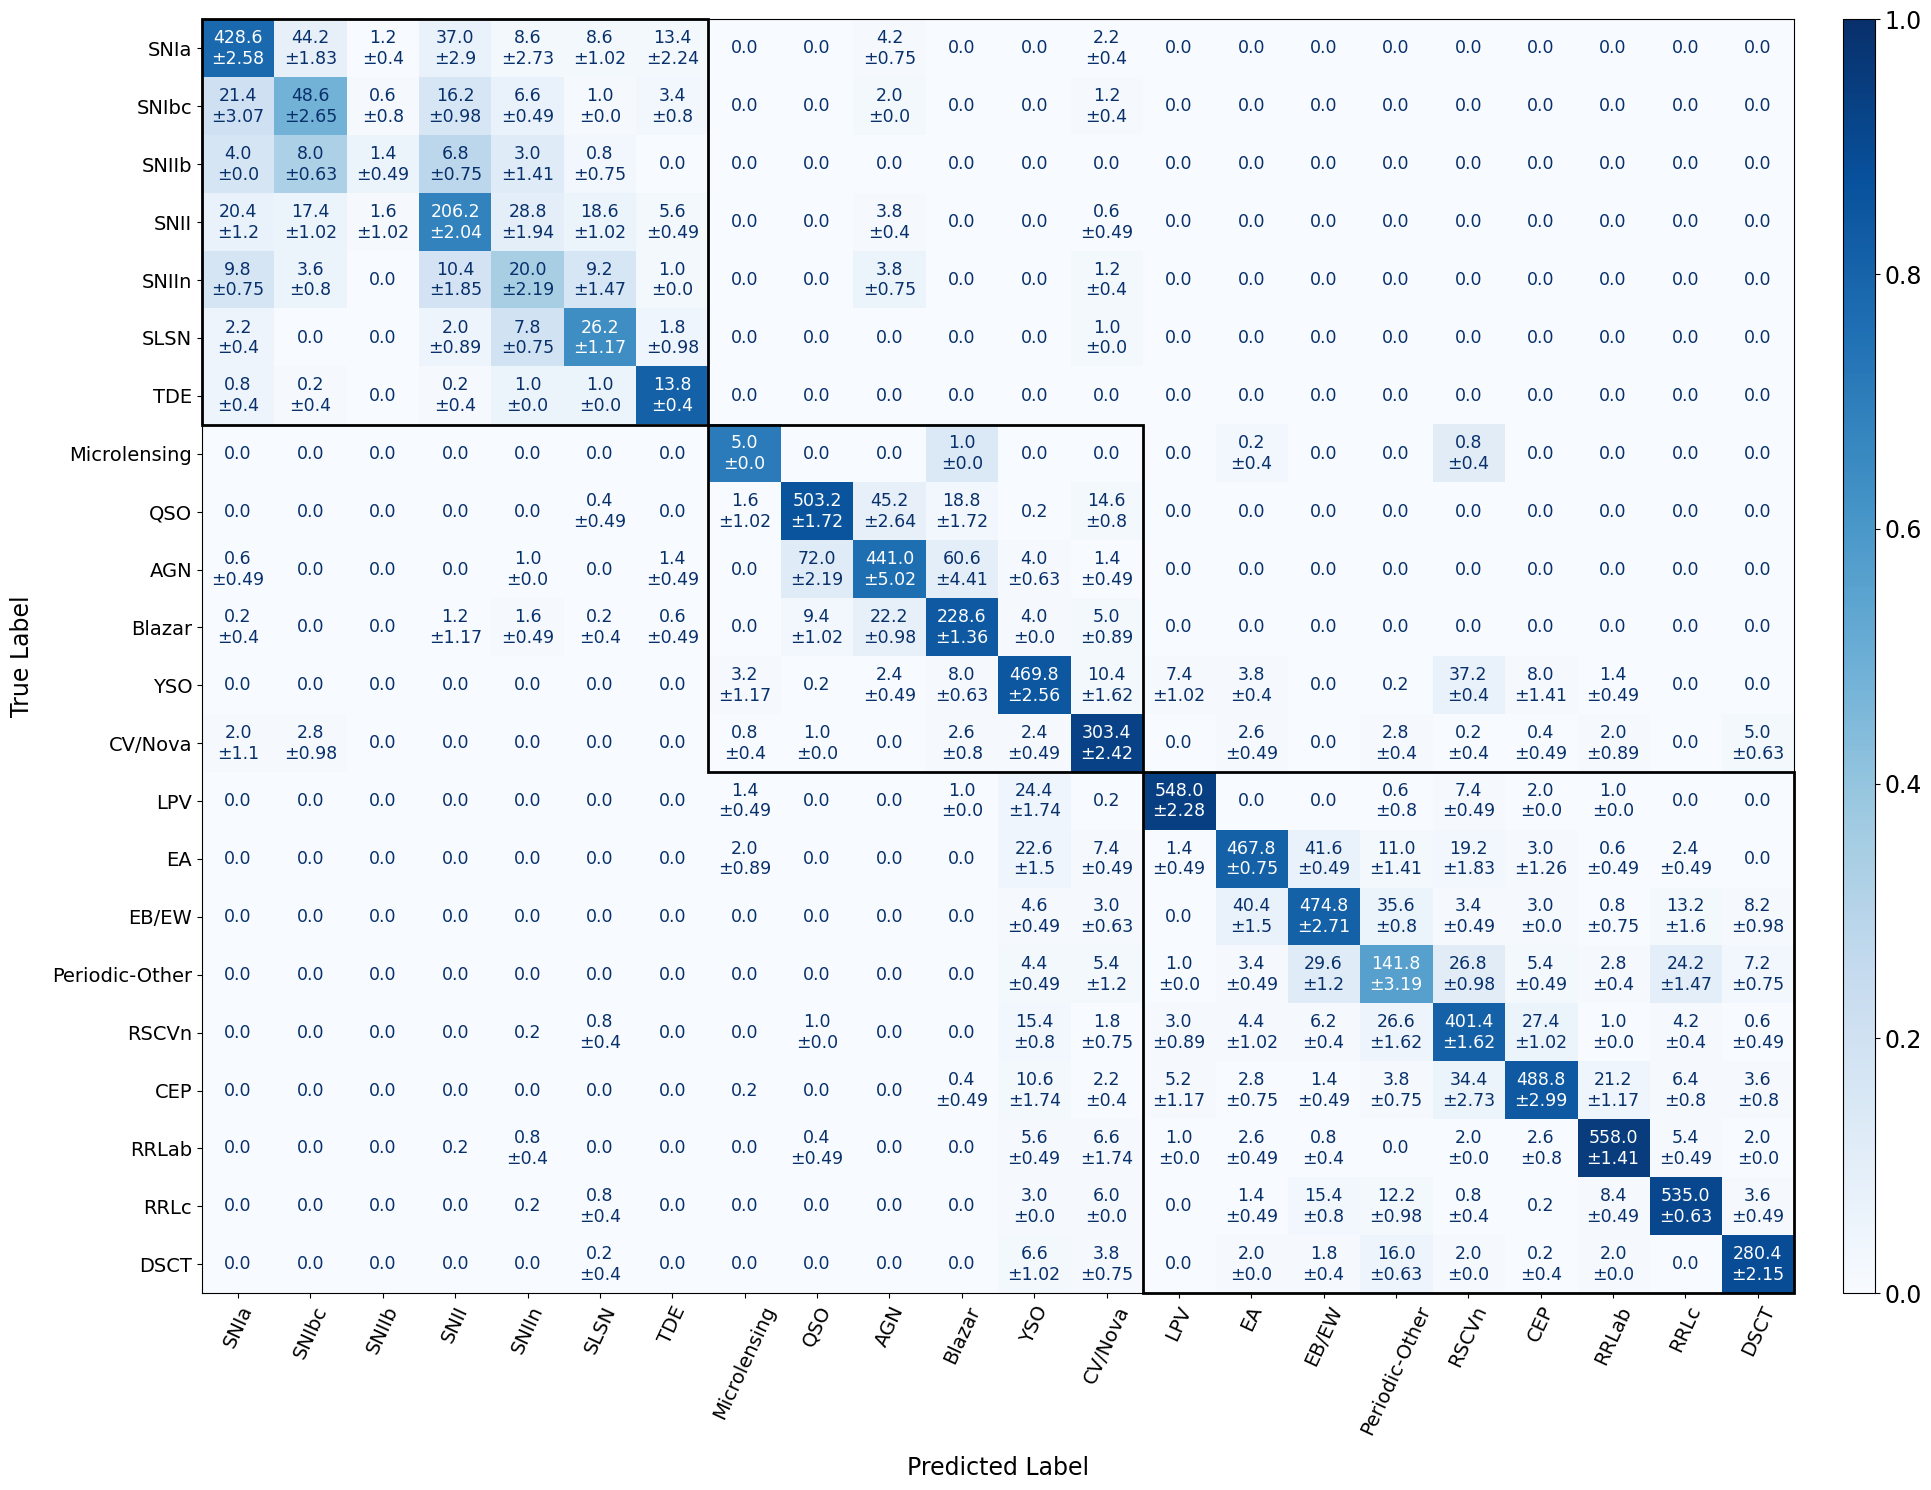

In [116]:
import pandas as pd
from sklearn.metrics import confusion_matrix

matrices = []
matrices_norm = []

num_folds = 5
for fold in range(num_folds):
    df_predictions = pd.read_parquet(f'fold_{fold}/predictions_test.parquet')
    df_predictions = df_predictions[df_predictions['shorten'] == 'None']
    y_test = df_predictions['y_true'].values
    y_pred = df_predictions['y_pred'].values
    cm = confusion_matrix(y_test, y_pred, labels=order_classes)#, normalize='true')
    cm_norm = confusion_matrix(y_test, y_pred, labels=order_classes, normalize='true')
    matrices.append(cm)
    matrices_norm.append(cm_norm)


# Calculando la media y la desviación estándar
mean_matrix = np.mean(matrices, axis=0)
std_matrix = np.std(matrices, axis=0)

mean_matrices_norm = np.mean(matrices_norm, axis=0)

path_save = 'cm_hbrf.pdf'
get_confusion_matrix(mean_matrix, std_matrix, mean_matrices_norm, order_classes, class_hierarchy, path_save, figsize=(25,15))

In [117]:
from sklearn.metrics import classification_report

# Leer las predicciones y calcular los reportes de métricas
num_folds = 5
report_metrics = []

for fold in range(num_folds):
    df_predictions = pd.read_parquet(f'fold_{fold}/predictions_test.parquet')
    df_predictions = df_predictions[df_predictions['shorten'] == 'None']
    y_test = df_predictions['y_true'].values
    y_pred = df_predictions['y_pred'].values
    report_metrics.append(classification_report(y_test, y_pred, output_dict=True))


# Calcular métricas por clase y macro promedio
data = []
for label in order_classes + ["Macro Avg"]:
    row = [label]
    for metric in ['precision', 'recall', 'f1-score']:
        values = [report_metrics[i_fold][label if label != "Macro Avg" else 'macro avg'][metric] * 100 for i_fold in range(num_folds)]
        row.append(f"{np.mean(values):.2f} ± {np.std(values):.2f}")
    data.append(row)

# Crear DataFrame con las métricas
df = pd.DataFrame(data, columns=["Class", "Precision", "Recall", "F1-score"]).set_index("Class")
df


,Precision,Recall,F1-score
Class,,,
SNIa,87.47 ± 0.57,78.21 ± 0.47,82.58 ± 0.42
SNIbc,38.94 ± 1.28,48.12 ± 2.63,43.03 ± 1.64
SNIIb,29.38 ± 6.87,5.83 ± 2.04,9.63 ± 3.05
SNII,73.64 ± 1.66,68.05 ± 0.67,70.72 ± 0.61
SNIIn,25.11 ± 1.17,33.90 ± 3.71,28.79 ± 1.91
SLSN,38.67 ± 0.78,63.90 ± 2.84,48.15 ± 0.90
TDE,33.89 ± 2.51,81.18 ± 2.35,47.72 ± 2.07
Microlensing,36.76 ± 7.58,71.43 ± 0.00,48.08 ± 6.61
QSO,85.70 ± 0.42,86.16 ± 0.29,85.93 ± 0.22


In [118]:
mapping = {
    "SNIa": "SNIa",
    "SNIbc": "SNIbc",
    "SNIIb": "Others",
    "SNII": "SNII",
    "SNIIn": "SNII",
    "SLSN": "SLSN",
    "TDE": "Others",  # Se ignora
    "Microlensing": "Others",  # Se ignora
    "QSO": "QSO",
    "AGN": "AGN",
    "Blazar": "Blazar",
    "YSO": "YSO",
    "CV/Nova": "CV/Nova",
    "LPV": "LPV",
    "EA": "E",
    "EB/EW": "E",
    "Periodic-Other": "Periodic-Other",
    "RSCVn": "Periodic-Other",
    "CEP": "CEP",
    "RRLab": "RRL",
    "RRLc": "RRL",
    "DSCT": "DSCT"
}

order_classes_sanchez_tax = [
    "SNIa", "SNIbc", "SNII", "SLSN",
    "QSO", "AGN", "Blazar",
    "YSO", "CV/Nova", "LPV", "E",
    "DSCT", "RRL", "CEP", "Periodic-Other", "Others"
    ]

class_hierarchy_sanchez_tax = {
    "Transient": ["SNIa", "SNIbc", "SNII", "SLSN"],
    "Periodic": [
        "LPV",
        "E",
        "Periodic-Other",
        "CEP",
        "RRL",
        "DSCT",
    ],
    "Stochastic": [
        "QSO",
        "AGN",
        "Blazar",
        "YSO",
        "CV/Nova",
    ],
}

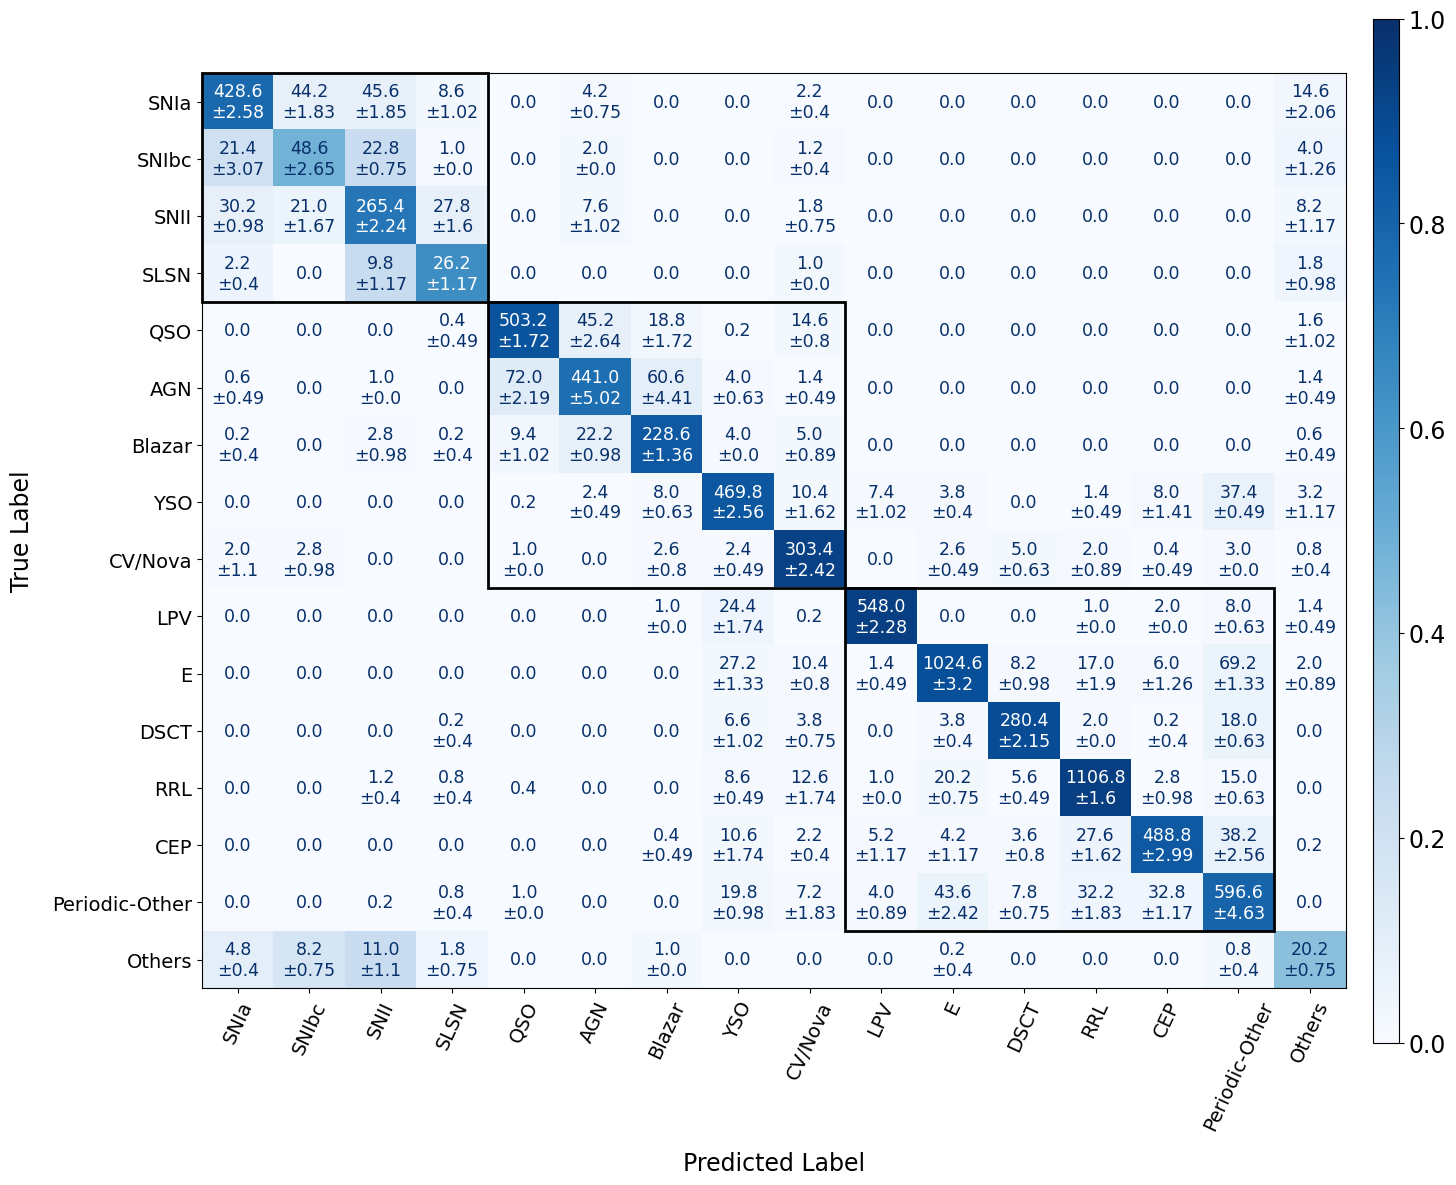

In [119]:
import pandas as pd
from sklearn.metrics import confusion_matrix

matrices = []
matrices_norm = []

num_folds = 5
for fold in range(num_folds):
    df_predictions = pd.read_parquet(f'fold_{fold}/predictions_test.parquet')
    df_predictions = df_predictions[df_predictions['shorten'] == 'None']
    y_test = df_predictions['y_true'].values
    y_pred = df_predictions['y_pred'].values

    y_test_sanchez_tax = [mapping[label] for label in y_test]
    y_pred_sanchez_tax = [mapping[label] for label in y_pred]

    cm = confusion_matrix(y_test_sanchez_tax, y_pred_sanchez_tax, labels=order_classes_sanchez_tax)#, normalize='true')
    matrices.append(cm)

    cm_norm = confusion_matrix(y_test_sanchez_tax, y_pred_sanchez_tax, labels=order_classes_sanchez_tax, normalize='true')
    matrices_norm.append(cm_norm)

# Calculando la media y la desviación estándar
mean_matrix = np.mean(matrices, axis=0)
std_matrix = np.std(matrices, axis=0)

mean_matrix_norm = np.mean(matrices_norm, axis=0)

path_save = 'cm_hbrf_sanchez_tax_nontrain.pdf'
get_confusion_matrix(mean_matrix, std_matrix, mean_matrix_norm, order_classes_sanchez_tax, class_hierarchy_sanchez_tax, path_save, figsize=(16,12))

In [120]:
from sklearn.metrics import classification_report

# Leer las predicciones y calcular los reportes de métricas
num_folds = 5
report_metrics = []

for fold in range(num_folds):
    df_predictions = pd.read_parquet(f'fold_{fold}/predictions_test.parquet')
    df_predictions = df_predictions[df_predictions['shorten'] == 'None']
    y_test = [mapping[label] for label in df_predictions['y_true'].values]
    y_pred = [mapping[label] for label in df_predictions['y_pred'].values]
    report_metrics.append(classification_report(y_test, y_pred, output_dict=True))

# Calcular métricas por clase y macro promedio
data = []
for label in order_classes_sanchez_tax + ["Macro Avg"]:
    row = [label]
    for metric in ['precision', 'recall', 'f1-score']:
        values = [report_metrics[i_fold][label if label != "Macro Avg" else 'macro avg'][metric] * 100 for i_fold in range(num_folds)]
        row.append(f"{np.mean(values):.2f} ± {np.std(values):.2f}")
    data.append(row)

# Crear DataFrame con las métricas
df = pd.DataFrame(data, columns=["Class", "Precision", "Recall", "F1-score"]).set_index("Class")
df


,Precision,Recall,F1-score
Class,,,
SNIa,87.47 ± 0.57,78.21 ± 0.47,82.58 ± 0.42
SNIbc,38.94 ± 1.28,48.12 ± 2.63,43.03 ± 1.64
SNII,73.76 ± 0.18,73.31 ± 0.62,73.54 ± 0.35
SLSN,38.67 ± 0.78,63.90 ± 2.84,48.15 ± 0.90
QSO,85.70 ± 0.42,86.16 ± 0.29,85.93 ± 0.22
AGN,84.07 ± 0.46,75.77 ± 0.86,79.70 ± 0.57
Blazar,71.23 ± 0.80,83.74 ± 0.50,76.97 ± 0.32
YSO,81.34 ± 0.41,85.11 ± 0.46,83.18 ± 0.18
CV/Nova,80.41 ± 1.29,92.50 ± 0.74,86.03 ± 0.82
